In [1]:
import math
from pickletools import optimize
import pandas as pd
import yfinance as yf
import numpy as np
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler



msft = yf.Ticker("MSFT")
df = msft.history(start ='2000-01-01' , end = '2019-01-01')
df.to_csv('../CSV/msft.csv')

df = pd.read_csv('../CSV/msft.csv')

#data set for training
data = df.filter(['Close'])
dataset = data.values

#scales data into 1-0
scaler = MinMaxScaler(feature_range=(0,1))
scaler_data = scaler.fit_transform(dataset)

#training sets 
train_size = int(df.shape[0] * 0.8)
train_set = scaler_data[0: train_size, :]

x_train = []
y_train = []

for i in range(60, train_size):
    x_train.append(train_set[i-60: i, 0])
    y_train.append(train_set[i,0])



x_train, y_train = np.array(x_train), np.array(y_train)

x_train = np.reshape(x_train,(x_train.shape[0],x_train.shape[1],1))

model = tf.keras.Sequential()
model.add(tf.keras.layers.LSTM(50, return_sequences=True, input_shape = (x_train.shape[1],1)))
model.add(tf.keras.layers.LSTM(50, return_sequences=False))
model.add(tf.keras.layers.Dense(25))
model.add(tf.keras.layers.Dense(1))

model.compile(optimizer='adam', loss='mean_squared_error')

model.fit(x_train, y_train, batch_size = 1, epochs = 1)


2022-05-17 18:00:46.003858: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


3763/3763 [==============================] - 155s 40ms/step - loss: 1.7029e-04


0.4888410847556145


/var/folders/w_/bcbslvsd4cz_kwppplndj7gc0000gn/T/ipykernel_3231/2318488631.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid['Predictions'] = predictions


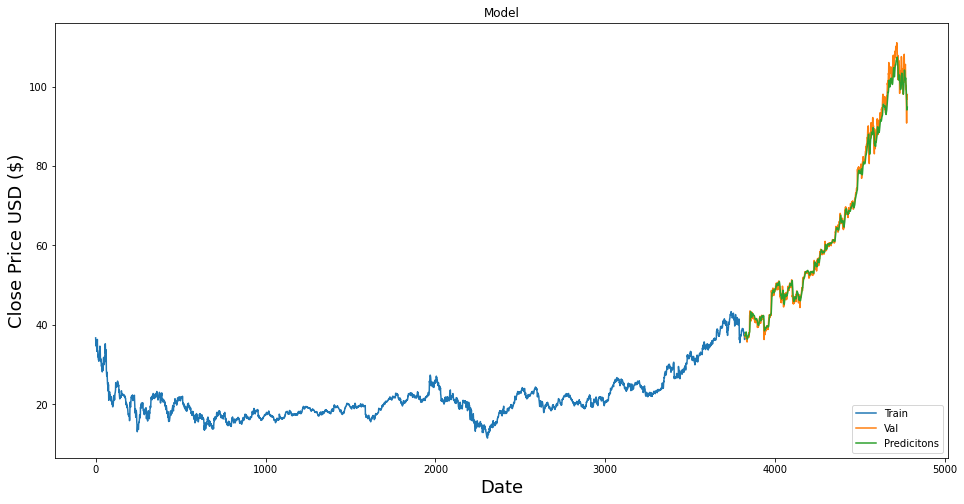

<Figure size 432x288 with 0 Axes>

In [2]:
test_data = scaler_data[train_size -60:, :]

x_test = []
y_test = dataset[train_size:, :]
for i in range(60, len(test_data)):
    x_test.append(test_data[i-60:i, 0])


x_test = np.array(x_test)
x_test = np.reshape(x_test,(x_test.shape[0],x_test.shape[1],1))

predictions = model.predict(x_test)
predictions = scaler.inverse_transform(predictions)

rmse = np.sqrt(np.mean( predictions - y_test)**2)

print(rmse)

train = data[:train_size]
valid = data[train_size:]
valid['Predictions'] = predictions

#Visualize
plt.figure(figsize=(16,8))
plt.title('Model')
plt.xlabel('Date', fontsize = 18)
plt.ylabel('Close Price USD ($)', fontsize = 18)
plt.plot(train["Close"])
plt.plot(valid[['Close', 'Predictions']])
plt.legend(['Train', 'Val', 'Predicitons'], loc = 'lower right')
plt.show()
plt.savefig("../plots/visualize.png")

In [3]:
apple = yf.Ticker("AAPL")
df = apple.history(start ='2015-01-01', end = '2016-01-01')
new_df = df.filter(['Close'])
data = new_df[-60:].values

data_scaled = scaler.transform(data)
apple_60_predictions = []

for i in range(60):
    x_test = []
    x_test.append(data_scaled)
    x_test = np.array(x_test)
    x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))

    pred_price = model.predict(x_test)
    data_scaled= np.concatenate((data_scaled[1:], [[pred_price[0][0]]]))
    pred_price = scaler.inverse_transform(pred_price)
    apple_60_predictions.append(pred_price[0][0])

df = apple.history(start ='2016-01-01')
print("Predictions" , "Actual")
for i in range(60):
    print(apple_60_predictions[i],"    ", df['Close'][i])


Predictions Actual
25.143332      24.185041427612305
25.206688      23.578983306884766
25.337448      23.1175479888916
25.493952      22.141883850097656
25.658878      22.258962631225586
25.824461      22.619386672973633
25.986986      22.947669982910156
26.144674      22.357677459716797
26.296808      22.846660614013672
26.443306      22.297988891601562
26.58452      22.190093994140625
26.721035      22.219940185546875
26.853596      22.10744857788086
26.982965      23.2828369140625
27.109915      22.82829475402832
27.235146      22.954551696777344
27.359245      21.4462947845459
27.482712      21.6001033782959
27.605928      22.346195220947266
27.729164      22.13729476928711
27.852598      21.689632415771484
27.976324      22.118928909301758
28.100372      22.296649932861328
28.224726      21.70114517211914
28.349318      21.929656982421875
28.474085      21.9250431060791
28.598938      21.75885581970215
28.72379      21.627288818359375
28.84855      21.694229125976562
28.973158    

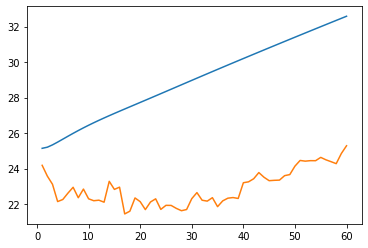

In [4]:
index = []
for i in range(60):
    index.append(i+1)

plt.plot(index, apple_60_predictions , 
        index , df['Close'][:60] )
plt.show()